In [ ]:
!pip install colorama -q
!pip install transformers -q
!pip install tokenizers -q
!pip install SentencePiece -q

     |████████████████████████████████| 4.4 MB 8.9 MB/s 
     |████████████████████████████████| 596 kB 72.2 MB/s 
     |████████████████████████████████| 86 kB 6.2 MB/s 
     |████████████████████████████████| 6.6 MB 57.7 MB/s 
     |████████████████████████████████| 1.2 MB 8.9 MB/s 


In [ ]:
import json
import os
import re
import sys

import requests
import string
import numpy as np
from colorama import Fore
from tokenizers import BertWordPieceTokenizer
from tqdm import tqdm
from transformers import CamembertTokenizer, CamembertModel, BertModel, BertTokenizer
import torch
import torch.nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [ ]:
!mkdir "/content/camembertFquad"

In [ ]:
!unzip "/content/drive/MyDrive/download-form-fquad1.0.zip" -d "/content/fquad/"

Archive:  /content/drive/MyDrive/download-form-fquad1.0.zip
  inflating: /content/fquad/train.json  
  inflating: /content/fquad/__MACOSX/._train.json  
  inflating: /content/fquad/valid.json  
  inflating: /content/fquad/__MACOSX/._valid.json  


In [ ]:
class Config:
  DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  MAX_SEQ_LENGTH = 384
  BATCH_SIZE = 8
  EPOCHS = 7

In [ ]:
def read_squad(path):
    with open(path, 'rb') as f:
        squad_dict = json.load(f)

    # initialize lists for contexts, questions, and answers
    contexts = []
    questions = []
    answers = []
    # iterate through all data in squad data
    for group in squad_dict['data']:
        for passage in group['paragraphs']:
            context = passage['context']
            for qa in passage['qas']:
                question = qa['question']
                if 'plausible_answers' in qa.keys():
                    access = 'plausible_answers'
                else:
                    access = 'answers'
                for answer in qa['answers']:
                    # append data to lists
                    contexts.append(context)
                    questions.append(question)
                    answers.append(answer)
    # return formatted data lists
    return contexts, questions, answers

In [ ]:

train_contexts, train_questions, train_answers = read_squad('/content/fquad/train.json')
val_contexts, val_questions, val_answers = read_squad('/content/fquad/valid.json')

In [ ]:
def add_end_idx(answers, contexts):
    # loop through each answer-context pair
    for answer, context in zip(answers, contexts):
        # gold_text refers to the answer we are expecting to find in context
        gold_text = answer['text']
        # we already know the start index
        start_idx = answer['answer_start']
        # and ideally this would be the end index...
        end_idx = start_idx + len(gold_text)

        # ...however, sometimes squad answers are off by a character or two
        if context[start_idx:end_idx] == gold_text:
            # if the answer is not off :)
            answer['answer_end'] = end_idx
        else:
            for n in [1, 2]:
                if context[start_idx-n:end_idx-n] == gold_text:
                    # this means the answer is off by 'n' tokens
                    answer['answer_start'] = start_idx - n
                    answer['answer_end'] = end_idx - n

In [ ]:
add_end_idx(train_answers, train_contexts)
add_end_idx(val_answers, val_contexts)

In [ ]:
train_answers[855]['answer_end']=429
train_answers[854]['answer_end']=339

Encode

In [ ]:
train_contexts[:6]

["L'idée selon laquelle une planète inconnue pourrait exister entre les orbites de Mars et Jupiter fut proposée pour la première fois par Johann Elert Bode en 1768. Ses suggestions étaient basées sur la loi de Titius-Bode, une théorie désormais obsolète proposée par Johann Daniel Titius en 1766,. Selon cette loi, le demi-grand axe de cette planète aurait été d'environ 2,8 ua. La découverte d'Uranus par William Herschel en 1781 accrut la confiance dans la loi de Titius-Bode et, en 1800, vingt-quatre astronomes expérimentés combinèrent leurs efforts et entreprirent une recherche méthodique de la planète proposée,. Le groupe était dirigé par Franz Xaver von Zach. Bien qu'ils n'aient pas découvert Cérès, ils trouvèrent néanmoins plusieurs autres astéroïdes.",
 "L'idée selon laquelle une planète inconnue pourrait exister entre les orbites de Mars et Jupiter fut proposée pour la première fois par Johann Elert Bode en 1768. Ses suggestions étaient basées sur la loi de Titius-Bode, une théorie

In [ ]:
train_questions[:6]

["Quel astronome a émit l'idée en premier d'une planète entre les orbites de Mars et Jupiter ?",
 'Quel astronome découvrit Uranus ?',
 'Quelles furent les découvertes finales des vingt-quatre astronomes ?',
 'Quelles furent les découvertes finales des vingt-quatre astronomes ?',
 'Combien de fois Piazzi est-il parvenu à observer Cérès ?',
 'Où se trouvait Barnaba Oriani en 1801 ?']

In [ ]:
from transformers import CamembertTokenizer, CamembertTokenizerFast
from transformers import CamembertModel
tokenizer = CamembertTokenizerFast.from_pretrained('camembert-base')

train_encodings = tokenizer(train_contexts, train_questions, truncation=True, padding=True)
val_encodings = tokenizer(val_contexts, val_questions, truncation=True, padding=True)

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.33M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/508 [00:00<?, ?B/s]

In [ ]:
def add_token_positions(encodings, answers):
    # initialize lists to contain the token indices of answer start/end
    start_positions = []
    end_positions = []
    for i in range(len(answers)):
        # append start/end token position using char_to_token method
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end']))

        # if start position is None, the answer passage has been truncated
        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length
        # end position cannot be found, char_to_token found space, so shift one token forward
        go_back = 1
        while end_positions[-1] is None:
            end_positions[-1] = encodings.char_to_token(i, answers[i]['answer_end']-go_back)
            go_back +=1
    # update our encodings object with the new token-based start/end positions
    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})



In [ ]:
# apply function to our data
add_token_positions(val_encodings, val_answers)
add_token_positions(train_encodings, train_answers)

Model : Camembert 

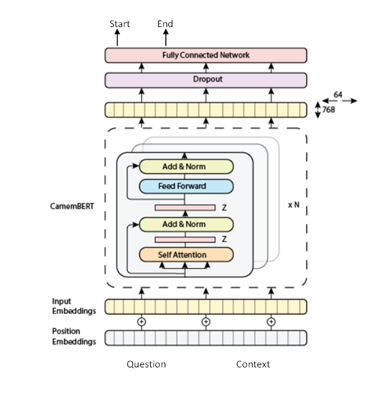

In [ ]:
import torch

class FquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

train_dataset = FquadDataset(train_encodings)
val_dataset = FquadDataset(val_encodings)

In [ ]:
import torch
from torch import nn
from torch.nn import CrossEntropyLoss

import transformers
 
class CamemBertForQuestionAnswering(nn.Module):
    def __init__(self):
        super(CamemBertForQuestionAnswering, self).__init__()
        self.camembert = CamembertModel.from_pretrained('camembert-base', return_dict=False, add_pooling_layer=False)
        self.qa_outputs = nn.Linear(768, 2)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, start_positions=None, end_positions=None):
        outputs = self.camembert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        sequence_output = outputs[0]
        logits = self.qa_outputs(sequence_output)

        start_logits, end_logits = logits.split(1, dim=-1)
        start_logits = start_logits.squeeze(-1)
        end_logits = end_logits.squeeze(-1)

        if start_positions is not None and end_positions is not None:
            # If we are on multi-GPU, split add a dimension
            if len(start_positions.size()) > 1:
                start_positions = start_positions.squeeze(-1)
            if len(end_positions.size()) > 1:
                end_positions = end_positions.squeeze(-1)
            # sometimes the start/end positions are outside our model inputs, we ignore these terms
            ignored_index = start_logits.size(1)
            start_positions.clamp_(0, ignored_index)
            end_positions.clamp_(0, ignored_index)

            loss_fct = nn.CrossEntropyLoss(ignore_index=ignored_index)
            start_loss = loss_fct(start_logits, start_positions)
            end_loss = loss_fct(end_logits, end_positions)
            total_loss = (start_loss + end_loss) / 2

            output = (start_logits, end_logits) + outputs[2:]
            return ((total_loss,) + output) if total_loss is not None else output
        else:
            return start_logits, end_logits

In [ ]:
# Model
model = CamemBertForQuestionAnswering().to(device=Config.DEVICE)

Downloading:   0%|          | 0.00/424M [00:00<?, ?B/s]

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing CamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def compute_f1(prediction, truth):
    
    prediction = "".join(ch for ch in prediction if ch not in set(string.punctuation))
    truth = "".join(ch for ch in truth if ch not in set(string.punctuation))
    pred_tokens = prediction.split()
    truth_tokens = truth.split()
    
    # if either the prediction or the truth is no-answer then f1 = 1 if they agree, 0 otherwise
    if len(pred_tokens) == 0 or len(truth_tokens) == 0:
        return int(pred_tokens == truth_tokens)
    
    common_tokens = set(pred_tokens) & set(truth_tokens)
    
    # if there are no common tokens then f1 = 0
    if len(common_tokens) == 0:
        return 0
    
    prec = len(common_tokens) / len(pred_tokens)
    rec = len(common_tokens) / len(truth_tokens)
    
    return 2 * (prec * rec) / (prec + rec)

In [ ]:
from torch.utils.data import DataLoader
from transformers import AdamW
from tqdm import tqdm
from statistics import mean

# setup GPU/CPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# move model over to detected device
#model.to(device)
# activate training mode of model
model.train()
# initialize adam optimizer with weight decay (reduces chance of overfitting)
optim = AdamW(model.parameters(), lr=5e-5)

# initialize data loader for training data
train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True)
#val_sampler = SequentialSampler(val_dataset)
val_loader = DataLoader(val_dataset, batch_size=Config.BATCH_SIZE)

for epoch in range(1, Config.EPOCHS + 1):

# ============================================ Training ==========================================================
    # set model to train mode
    model.train()
    # setup loop (we use tqdm for the progress bar)
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        # initialize calculated gradients (from prev step)
        optim.zero_grad()
        # pull all the tensor batches required for training
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        # train model on batch and return outputs (incl. loss)
        outputs = model(input_ids, attention_mask=attention_mask,
                        start_positions=start_positions,
                        end_positions=end_positions)
        # extract loss
        loss = outputs[0]
        # calculate loss for every parameter that needs grad update
        loss.backward()
        # update parameters
        optim.step()
        # print relevant info to progress bar
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())
    torch.save(model.state_dict(), "./camembertFquad/weights_" + str(epoch) + ".pth")

# ============================================ VALIDATION ==========================================================

    # switch model out of training mode
    model.eval()
    currentIdx = 0
    acc = []
    f1_scores=[]
    # initialize loop for progress bar
    loop = tqdm(val_loader)
    # loop through batches
    for batch in loop:
        # we don't need to calculate gradients as we're not training
        with torch.no_grad():
            # pull batched items from loader
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_true = batch['start_positions'].to(device).detach().cpu().numpy()
            end_true = batch['end_positions'].to(device).detach().cpu().numpy()
            # make predictions
            outputs = model(input_ids, attention_mask=attention_mask)
            # pull preds out
            start_pred = torch.argmax(outputs[0], dim=1).detach().cpu().numpy()
            end_pred = torch.argmax(outputs[1], dim=1).detach().cpu().numpy()

            for idx, (start, end) in enumerate(zip(start_pred, end_pred)):
              #context = val_contexts[currentIdx]
              pred_answer = tokenizer.decode(list(val_encodings['input_ids'][currentIdx])[start:end+1])
              #pred_answer = context[start:end]
              true_answer = tokenizer.decode(list(val_encodings['input_ids'][currentIdx])[start_true[idx]:end_true[idx]+1])
              #true_answer = val_answers[currentIdx]["text"]
              currentIdx += 1
              f1_score = compute_f1(pred_answer, true_answer)
              f1_scores.append(f1_score)
    f1 = mean(f1_scores)
    print(f"\nEpoch={epoch},   F1-score = {f1:.2f}")


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
100%|██████████| 399/399 [00:57<00:00,  6.99it/s]



Epoch=1,   F1-score = 0.75


100%|██████████| 399/399 [00:57<00:00,  6.99it/s]



Epoch=2,   F1-score = 0.76


100%|██████████| 399/399 [00:57<00:00,  6.97it/s]



Epoch=3,   F1-score = 0.75


100%|██████████| 399/399 [00:57<00:00,  6.99it/s]



Epoch=4,   F1-score = 0.75


100%|██████████| 399/399 [00:57<00:00,  6.95it/s]



Epoch=5,   F1-score = 0.75


100%|██████████| 399/399 [00:57<00:00,  6.95it/s]



Epoch=6,   F1-score = 0.74


100%|██████████| 399/399 [00:57<00:00,  6.95it/s]


Epoch=7,   F1-score = 0.74


# Exemple

In [ ]:
passage = ["Mehdi est un homme agé de 24 ans, il est en train de préparer son projet de fin d'étude"]
ques = ["quel est l'age de Mehdi ?"]

In [ ]:
encod = tokenizer(passage, ques, truncation=True, padding=True)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
input = torch.tensor(encod['input_ids']).to(device)
msk = torch.tensor(encod['attention_mask']).to(device)

In [ ]:
output = model(input_ids = input, attention_mask=msk)

In [ ]:
start_pred = torch.argmax(output[0]).detach().cpu().numpy()
end_pred = torch.argmax(output[1]).detach().cpu().numpy()
print('start_pred : ', start_pred)
print('end_pred : ',end_pred)

start_pred :  8
end_pred :  10


In [ ]:
tokenizer.decode(list(encod['input_ids'][0])[start_pred:end_pred])

'24 ans'

batch_size=4

In [ ]:
class Config:
  DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
 
  BATCH_SIZE = 4
  EPOCHS = 5

In [ ]:
# Model2
model2 = CamemBertForQuestionAnswering().to(device=Config.DEVICE)

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing CamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
!mkdir "/content/camembertFquad_v2"

In [ ]:
from torch.utils.data import DataLoader
from transformers import AdamW
from tqdm import tqdm
from statistics import mean

# setup GPU/CPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# move model over to detected device
#model.to(device)
# activate training mode of model
model2.train()
# initialize adam optimizer with weight decay (reduces chance of overfitting)
optim = AdamW(model2.parameters(), lr=5e-5)

# initialize data loader for training data
train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True)
#val_sampler = SequentialSampler(val_dataset)
val_loader = DataLoader(val_dataset, batch_size=Config.BATCH_SIZE)

for epoch in range(1, Config.EPOCHS + 1):
    

# ============================================ Training ==========================================================

    # set model to train mode
    model2.train()
    # setup loop (we use tqdm for the progress bar)
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        # initialize calculated gradients (from prev step)
        optim.zero_grad()
        # pull all the tensor batches required for training
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        # train model on batch and return outputs (incl. loss)
        outputs = model2(input_ids, attention_mask=attention_mask,
                        start_positions=start_positions,
                        end_positions=end_positions)
        # extract loss
        loss = outputs[0]
        # calculate loss for every parameter that needs grad update
        loss.backward()
        # update parameters
        optim.step()
        # print relevant info to progress bar
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())
    torch.save(model2.state_dict(), "./camembertFquad_v2/weights_" + str(epoch) + ".pth")

# ============================================ VALIDATION ==========================================================

    # switch model out of training mode
    model2.eval()

    #answers = val_answers
    #context = val_contexts
    currentIdx = 0

    acc = []
    f1_scores=[]

    # initialize loop for progress bar
    loop = tqdm(val_loader)
    # loop through batches
    for batch in loop:
        # we don't need to calculate gradients as we're not training
        with torch.no_grad():
            # pull batched items from loader
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_true = batch['start_positions'].to(device).detach().cpu().numpy()
            end_true = batch['end_positions'].to(device).detach().cpu().numpy()
            # make predictions
            outputs = model2(input_ids, attention_mask=attention_mask)
            # pull preds out
            start_pred = torch.argmax(outputs[0], dim=1).detach().cpu().numpy()
            end_pred = torch.argmax(outputs[1], dim=1).detach().cpu().numpy()

            for idx, (start, end) in enumerate(zip(start_pred, end_pred)):
              #context = val_contexts[currentIdx]
              pred_answer = tokenizer.decode(list(val_encodings['input_ids'][currentIdx])[start:end+1])
              #pred_answer = context[start:end]
              true_answer = tokenizer.decode(list(val_encodings['input_ids'][currentIdx])[start_true[idx]:end_true[idx]+1])
              #true_answer = val_answers[currentIdx]["text"]
              currentIdx += 1
              f1_score = compute_f1(pred_answer, true_answer)
              f1_scores.append(f1_score)
    #print(f1_scores)
    f1 = mean(f1_scores)
    print(f"\nEpoch={epoch},   F1-score = {f1:.2f}")



            # calculate accuracy for both and append to accuracy list
            #acc.append(((start_pred == start_true).sum()/len(start_pred)).item())
            #acc.append(((end_pred == end_true).sum()/len(end_pred)).item())
    # calculate average accuracy in total
    #acc = sum(acc)/len(acc)'''
    #print(f"\nEpoch={epoch}, exact match score={acc:.2f}")

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
100%|██████████| 797/797 [00:58<00:00, 13.73it/s]



Epoch=1,   F1-score = 0.74


100%|██████████| 797/797 [00:58<00:00, 13.71it/s]



Epoch=2,   F1-score = 0.74


100%|██████████| 797/797 [00:58<00:00, 13.70it/s]



Epoch=3,   F1-score = 0.76


100%|██████████| 797/797 [00:58<00:00, 13.73it/s]



Epoch=4,   F1-score = 0.74


100%|██████████| 797/797 [00:58<00:00, 13.73it/s]


Epoch=5,   F1-score = 0.74
